<a href="https://colab.research.google.com/github/YairYarden/Deep-Learning/blob/feature%2Fassignment1_LeNet5/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is influenced by [This](https://boscoj2008.github.io/LeNet-5/) forum



# Imports

In [33]:
import torch
import numpy as np
from datetime import datetime 
import os

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import ssl

import matplotlib.pyplot as plt

# check if CUDA is available
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DIR_PATH = '/content/drive/MyDrive/Deep learning 05107255/ex1_316168061_313471526'


CUDA is available!  Training on GPU ...


In [34]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [35]:
ssl._create_default_https_context = ssl._create_unverified_context

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.3814, std=0.3994)
    ])

# choose the training and test datasets
train_data = datasets.FashionMNIST('data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST('data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Visualize a batch of training data



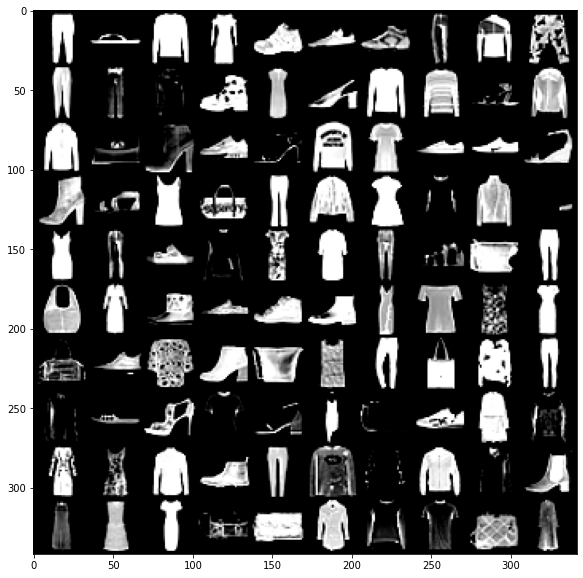

In [36]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10,10))
grid = torchvision.utils.make_grid(tensor=images, nrow=10)
grid = np.clip(grid,0,1)
plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");


# Define The Network

In [37]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class LeNet5(nn.Module):
    def conv_block_1(self, in_features, out_features, kernel_size, use_pooling=True, use_dropout=False, use_batchnorm=False):
      layers = [nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=kernel_size, stride=1)]
      if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_features))
      layers.append(nn.Tanh())
      if use_pooling:
        layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
      block = nn.Sequential(*layers)
      return block

    def conv_block_2(self, in_features, out_features, kernel_size, use_pooling=True, use_dropout=False, use_batchnorm=False):
      layers = [nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=kernel_size, stride=1)]
      if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_features))
      layers.append(nn.Tanh())
      block = nn.Sequential(*layers)
      return block

    def fc_block_1(self, in_features, out_features, use_dropout=False, use_batchnorm=False, dropout=0.25):
      layers = [nn.Linear(in_features=in_features , out_features=out_features)]
      if use_batchnorm:
        layers.append(nn.BatchNorm1d(out_features))
      layers.append(nn.Tanh()) 
      if use_dropout:
        layers.append(nn.Dropout(dropout))
      block = nn.Sequential(*layers)
      return block

    def fc_block_2(self, in_features, out_features, use_dropout=False, use_batchnorm=False):
      layers = [nn.Linear(in_features=in_features , out_features=out_features)]
      if use_batchnorm:
        layers.append(nn.BatchNorm1d(out_features)) 
      block = nn.Sequential(*layers)
      return block


    def __init__(self, n_classes=10, use_dropout=False, use_batchnorm=False):
        super(LeNet5, self).__init__()
        # convolutional layer (sees 32x32x1 image tensor)
        self.conv_layer1 = self.conv_block_1(1, 6, 5, True, use_dropout, use_batchnorm)
        # convolutional layer (sees 28x28x6 tensor)
        self.conv_layer2 = self.conv_block_1(6, 16, 5, True, use_dropout, use_batchnorm)
        # convolutional layer (sees 10x10x16 tensor)
        self.conv_layer3 = self.conv_block_2(16, 120, 5, False, use_dropout, use_batchnorm)
        # Flatten 
        self.flatten = nn.Flatten(start_dim=1)
        # linear layer sees 120 -> 84
        self.fc1_layer = self.fc_block_1(120, 84, use_dropout, use_batchnorm)
        # linear layer (84 -> n_classes)
        self.fc2_layer = self.fc_block_2(84, n_classes, use_dropout, use_batchnorm)

        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        # flatten image input
        x = x.view(-1, 120)

        # add 1st hidden layer, with relu activation function
        x = self.fc1_layer(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2_layer(x)
        return x

# create a complete CNN
num_classes = 10
model = LeNet5(num_classes, use_dropout=True, use_batchnorm=True).to(DEVICE)
print(model)

LeNet5(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1_layer): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc2_lay

# Specify Default Loss function & Optimizer

In [38]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Functions For Training the network

In [39]:
def compute_model_accuracy(model, data_loader, is_gpu_available):
    
    correct_pred = 0 
    num_examples = 0
    
    with torch.no_grad():
        model.eval()
        for data, target in data_loader:
            if is_gpu_available:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            _, predicted_labels = torch.max(output, 1) 

            num_examples += target.size(0)
            correct_pred += (predicted_labels == target).sum()

    return correct_pred.float() / num_examples
    
# --------------------------------------------------------------------------------------------------
def train(train_loader, model, criterion, optimizer, is_gpu_available):
    running_loss = 0.0
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        running_loss += loss.item()*data.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss
# --------------------------------------------------------------------------------------------------
def test(test_loader, model, criterion, is_gpu_available):
    running_loss = 0.0

    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if is_gpu_available:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        running_loss += loss.item()*data.size(0)
    
    # calculate average losses
    valid_loss = running_loss/len(valid_loader.sampler)
               
    return model, valid_loss      
# --------------------------------------------------------------------------------------------------
def training_loop(model,
                  criterion,
                  optimizer,
                  train_loader,
                  test_loader,
                  epochs,
                  is_gpu_available,
                  log_dir: str = None,
                  train_type=None):
     
    # set objects for storing metrics
    train_losses = []
    test_losses = []
    train_acc_vec = []
    test_acc_vec = []

    print(f'{datetime.now().time().replace(microsecond=0)} START')

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, is_gpu_available)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, test_loss = test(test_loader, model, criterion, is_gpu_available)
            test_losses.append(test_loss)

            train_acc = compute_model_accuracy(model, train_loader, is_gpu_available)
            train_acc_vec.append(train_acc.cpu())
            test_acc = compute_model_accuracy(model, test_loader, is_gpu_available)
            test_acc_vec.append(test_acc.cpu())    
      

        print(
          f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Epoch: {epoch}\t'
          f'Train loss: {train_loss:.4f}\t'
          f'Test loss: {test_loss:.4f}\t'
          f'Train accuracy: {train_acc:.4f}\t'
          f'Test accuracy: {test_acc:.4f}'
        )

    # plot_train_and_valid_losses(train_losses, test_losses, train_type)
    plot_train_and_valid_acc(train_acc_vec, test_acc_vec, train_type)

    return model, optimizer, (train_losses, test_losses), (train_acc_vec, test_acc_vec)

# --------------------------------------------------------------------------------------------------


# Plotting & Helper Functions

In [40]:
def plot_train_and_valid_losses(train_losses, test_losses, train_type=None):
  
    train_losses = np.array(train_losses) 
    test_losses = np.array(test_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(test_losses, color='red', label='Validation loss')
    title = "Loss over epochs"
    if train_type:
      title += "\n" + train_type
    ax.set(title=title, 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    plt.grid()
    fig.show()
    
# --------------------------------------------------------------------------------------------------
def plot_train_and_valid_acc(train_acc, valid_acc, train_type=None):

    train_acc = np.array(train_acc) 
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_acc, color='blue', label='Training Accuracy') 
    ax.plot(valid_acc, color='red', label='Validation Accuracy')
    title = "Accuracy over epochs"
    if train_type:
      title += "\n" + train_type
    ax.set(title=title, 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    return fig
# --------------------------------------------------------------------------------------------------
def save_model(model, optimizer, dir_path, train_type=None):
  # create checkpints folder
  checkpoint_folder = os.path.join(dir_path, 'checkpoints')
  os.makedirs(checkpoint_folder, exist_ok=True)
  # save model
  curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
  model_name = f'{curr_datetime}'.replace(':', '_')
  if train_type:
    model_name = train_type + '_' + model_name
    # model_name = train_type
  ckpt_path = os.path.join(checkpoint_folder, f'{model_name}.ckpt')
  torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'use_dropout': model.use_dropout,
    'use_batchnorm': model.use_batchnorm,
    
  }, ckpt_path)

  print(f'model saved to "{ckpt_path}"')
# --------------------------------------------------------------------------------------------------

# Train the Network

Basic Model

14:19:22 START
14:19:55 --- Epoch: 0	Train loss: 0.7091	Test loss: 0.5886	Train accuracy: 0.7714	Test accuracy: 0.7613
14:20:28 --- Epoch: 1	Train loss: 0.4297	Test loss: 0.4915	Train accuracy: 0.8198	Test accuracy: 0.8065
14:21:03 --- Epoch: 2	Train loss: 0.3718	Test loss: 0.4414	Train accuracy: 0.8390	Test accuracy: 0.8288
14:21:37 --- Epoch: 3	Train loss: 0.3401	Test loss: 0.4120	Train accuracy: 0.8548	Test accuracy: 0.8426
14:22:10 --- Epoch: 4	Train loss: 0.3172	Test loss: 0.3899	Train accuracy: 0.8631	Test accuracy: 0.8507
14:22:42 --- Epoch: 5	Train loss: 0.3015	Test loss: 0.3743	Train accuracy: 0.8691	Test accuracy: 0.8520
14:23:15 --- Epoch: 6	Train loss: 0.2868	Test loss: 0.3737	Train accuracy: 0.8713	Test accuracy: 0.8536
14:23:48 --- Epoch: 7	Train loss: 0.2760	Test loss: 0.3515	Train accuracy: 0.8820	Test accuracy: 0.8633
14:24:21 --- Epoch: 8	Train loss: 0.2661	Test loss: 0.3598	Train accuracy: 0.8769	Test accuracy: 0.8564
14:24:54 --- Epoch: 9	Train loss: 0.2576	Test los

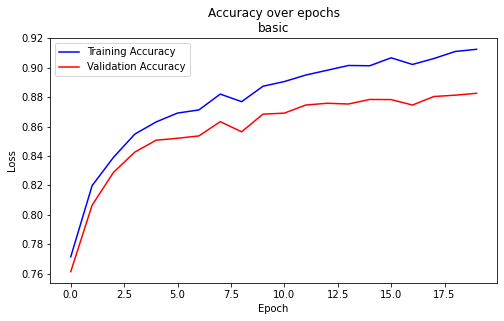

In [41]:
num_epochs = 20
learning_rate = 3e-4
# # basic network
basic_model = LeNet5(num_classes, use_dropout=False, use_batchnorm=False).to(DEVICE)
optimizer = torch.optim.Adam(basic_model.parameters(), lr=learning_rate)

basic_model, optimizer, (train_losses_basic, test_losses_basic), (train_acc_basic, test_acc_basic) = training_loop(basic_model, criterion, optimizer,
                                                                                                            train_loader, test_loader, num_epochs,
                                                                                                            is_gpu_available,
                                                                                                            train_type='basic')
save_model(basic_model, optimizer, DIR_PATH, train_type='basic')


Dropout Model

14:30:26 START
14:30:59 --- Epoch: 0	Train loss: 0.7311	Test loss: 0.5970	Train accuracy: 0.7707	Test accuracy: 0.7590
14:31:33 --- Epoch: 1	Train loss: 0.4451	Test loss: 0.4911	Train accuracy: 0.8202	Test accuracy: 0.8095
14:32:07 --- Epoch: 2	Train loss: 0.3860	Test loss: 0.4433	Train accuracy: 0.8389	Test accuracy: 0.8287
14:32:40 --- Epoch: 3	Train loss: 0.3510	Test loss: 0.4095	Train accuracy: 0.8556	Test accuracy: 0.8419
14:33:14 --- Epoch: 4	Train loss: 0.3283	Test loss: 0.3929	Train accuracy: 0.8620	Test accuracy: 0.8490
14:33:47 --- Epoch: 5	Train loss: 0.3098	Test loss: 0.3725	Train accuracy: 0.8701	Test accuracy: 0.8561
14:34:20 --- Epoch: 6	Train loss: 0.2969	Test loss: 0.3636	Train accuracy: 0.8755	Test accuracy: 0.8599
14:34:53 --- Epoch: 7	Train loss: 0.2828	Test loss: 0.3613	Train accuracy: 0.8799	Test accuracy: 0.8625
14:35:26 --- Epoch: 8	Train loss: 0.2747	Test loss: 0.3410	Train accuracy: 0.8863	Test accuracy: 0.8670
14:35:59 --- Epoch: 9	Train loss: 0.2671	Test los

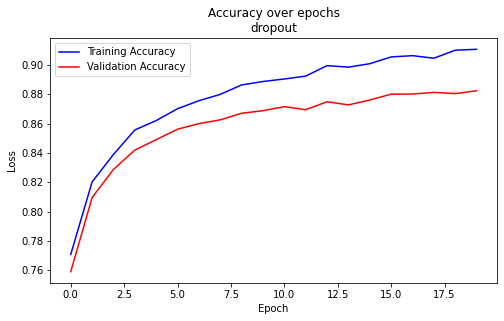

In [42]:
# using dropout
num_epochs = 20
learning_rate = 3e-4
dropout_model = LeNet5(num_classes, use_dropout=True, use_batchnorm=False).to(DEVICE)
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=learning_rate)
dropout_model, optimizer, (train_losses_dropout, test_losses_dropout), (train_acc_dropout, test_acc_dropout) = training_loop(dropout_model, criterion, optimizer,
                                                                                                                    train_loader, test_loader, num_epochs,
                                                                                                                    is_gpu_available,
                                                                                                                    train_type='dropout')
save_model(dropout_model, optimizer, DIR_PATH, train_type='dropout')

Weight Decay Model

14:41:33 START
14:42:06 --- Epoch: 0	Train loss: 0.7150	Test loss: 0.5974	Train accuracy: 0.7771	Test accuracy: 0.7659
14:42:40 --- Epoch: 1	Train loss: 0.4355	Test loss: 0.4923	Train accuracy: 0.8164	Test accuracy: 0.8067
14:43:12 --- Epoch: 2	Train loss: 0.3791	Test loss: 0.4499	Train accuracy: 0.8355	Test accuracy: 0.8259
14:43:45 --- Epoch: 3	Train loss: 0.3454	Test loss: 0.4154	Train accuracy: 0.8528	Test accuracy: 0.8415
14:44:19 --- Epoch: 4	Train loss: 0.3221	Test loss: 0.3993	Train accuracy: 0.8604	Test accuracy: 0.8452
14:44:51 --- Epoch: 5	Train loss: 0.3051	Test loss: 0.3913	Train accuracy: 0.8639	Test accuracy: 0.8510
14:45:24 --- Epoch: 6	Train loss: 0.2918	Test loss: 0.3706	Train accuracy: 0.8724	Test accuracy: 0.8575
14:45:57 --- Epoch: 7	Train loss: 0.2802	Test loss: 0.3629	Train accuracy: 0.8767	Test accuracy: 0.8607
14:46:30 --- Epoch: 8	Train loss: 0.2700	Test loss: 0.3510	Train accuracy: 0.8817	Test accuracy: 0.8653
14:47:03 --- Epoch: 9	Train loss: 0.2622	Test los

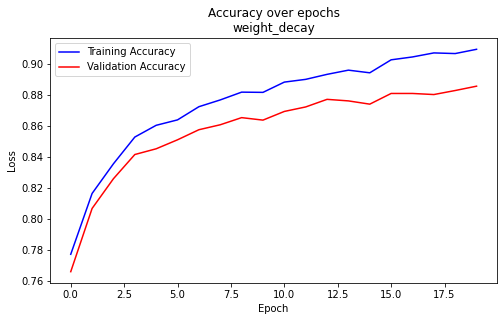

In [43]:
# using weight decay
num_epochs = 20
learning_rate = 3e-4
weight_decay = 1e-4
wd_model = LeNet5(num_classes, use_dropout=False, use_batchnorm=False).to(DEVICE)
optimizer = torch.optim.Adam(wd_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
wd_model, optimizer, (train_losses_wd, test_losses_wd), (train_acc_wd, test_acc_wd) = training_loop(wd_model, criterion, optimizer,
                                                                                                train_loader, test_loader, num_epochs,
                                                                                                is_gpu_available,
                                                                                                train_type='weight_decay')
save_model(wd_model, optimizer, DIR_PATH, train_type='weight_decay')

Batch norm Model

14:52:32 START
14:53:06 --- Epoch: 0	Train loss: 0.6361	Test loss: 0.6473	Train accuracy: 0.8412	Test accuracy: 0.8256
14:53:40 --- Epoch: 1	Train loss: 0.4694	Test loss: 0.5266	Train accuracy: 0.8758	Test accuracy: 0.8597
14:54:14 --- Epoch: 2	Train loss: 0.4038	Test loss: 0.4684	Train accuracy: 0.8874	Test accuracy: 0.8691
14:54:48 --- Epoch: 3	Train loss: 0.3647	Test loss: 0.4347	Train accuracy: 0.8848	Test accuracy: 0.8641
14:55:22 --- Epoch: 4	Train loss: 0.3320	Test loss: 0.3992	Train accuracy: 0.8991	Test accuracy: 0.8768
14:55:56 --- Epoch: 5	Train loss: 0.3070	Test loss: 0.3883	Train accuracy: 0.8981	Test accuracy: 0.8738
14:56:29 --- Epoch: 6	Train loss: 0.2857	Test loss: 0.3598	Train accuracy: 0.9076	Test accuracy: 0.8841
14:57:03 --- Epoch: 7	Train loss: 0.2699	Test loss: 0.3578	Train accuracy: 0.9047	Test accuracy: 0.8784
14:57:37 --- Epoch: 8	Train loss: 0.2551	Test loss: 0.3242	Train accuracy: 0.9175	Test accuracy: 0.8899
14:58:11 --- Epoch: 9	Train loss: 0.2432	Test los

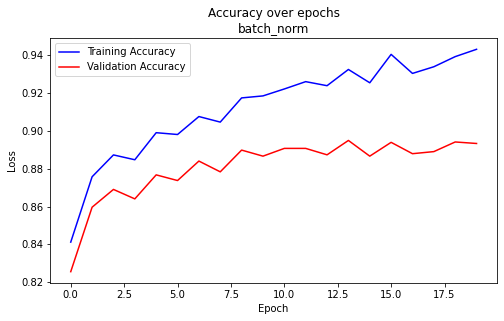

In [44]:
# using batch normalization
num_epochs = 20
learning_rate = 3e-4
bn_model = LeNet5(num_classes, use_dropout=False, use_batchnorm=True).to(DEVICE)
optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)

bn_model, optimizer, (train_losses_bn, test_losses_bn), (train_acc_bn, test_acc_bn) = training_loop(bn_model, criterion, optimizer,
                                                                                                  train_loader, test_loader, num_epochs,
                                                                                                  is_gpu_available,
                                                                                                  train_type='batch_norm')
save_model(bn_model, optimizer, DIR_PATH, train_type='batch_norm')

# Plot all models together

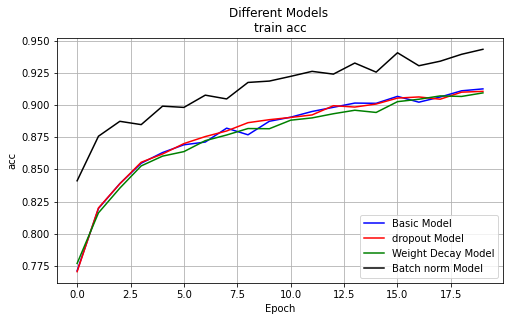

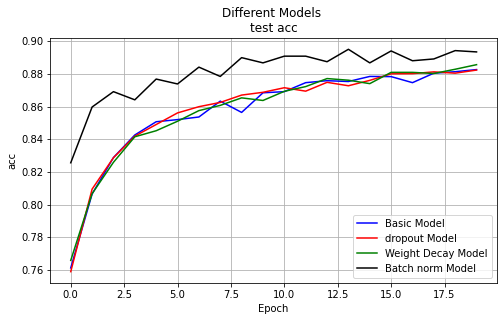

In [47]:
def plot_all_models(basic_vec, dropout_vec, weight_decay_vec, batch_norm_vec, plot_type = None):
  # Convert to numpy arrays
  basic_vec = np.array(basic_vec) 
  dropout_vec = np.array(dropout_vec) 
  weight_decay_vec = np.array(weight_decay_vec) 
  batch_norm_vec = np.array(batch_norm_vec) 

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(basic_vec, color='blue', label='Basic Model') 
  ax.plot(dropout_vec, color='red', label='dropout Model')
  ax.plot(weight_decay_vec, color='green', label='Weight Decay Model')
  ax.plot(batch_norm_vec, color='black', label='Batch norm Model')

  title = "Different Models "
  if plot_type:
    title += "\n" + plot_type

  if('loss' in plot_type):
    ylabel_name = 'loss'
  else:
    ylabel_name = 'acc'

  ax.set(title=title, 
          xlabel='Epoch',
          ylabel=ylabel_name) 
  ax.legend()
  plt.grid()
  fig.show()

# plot_all_models(train_losses_basic, train_losses_dropout, train_losses_wd, train_losses_bn, plot_type = 'train_loss')
# plot_all_models(test_losses_basic, test_losses_dropout, test_losses_wd, train_losses_bn, plot_type = 'test_loss')
plot_all_models(train_acc_basic, train_acc_dropout, train_acc_wd, train_acc_bn, plot_type = 'train acc')
plot_all_models(test_acc_basic, test_acc_dropout, test_acc_wd, test_acc_bn, plot_type = 'test acc')

# Test Pre-trained Models

In [46]:
is_test_all_models = True
if(is_test_all_models):
  chosen_model = ["basic", "dropout", "weight_decay", "batch_norm"]
else:
  chosen_model = "basic" #@param ["basic", "dropout", "weight_decay", "batch_norm"]
  chosen_model = [chosen_model];

for model_name in chosen_model:
  # load checkpoint
  ckpt_path = f'{DIR_PATH}/checkpoints/{model_name}.ckpt'
  checkpoint = torch.load(ckpt_path)

  N_CLASSES = 10
  model = LeNet5(N_CLASSES,
                use_dropout=checkpoint['use_dropout'],
                use_batchnorm=checkpoint['use_batchnorm']
                ).to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters())

  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  # run loaded model on test data
  model, test_loss = test(test_loader, model, criterion, is_gpu_available)
  test_acc = compute_model_accuracy(model, test_loader, is_gpu_available)

  print(
    f'Model name: {model_name} \t\t '
    f'Test accuracy: {test_acc:.4f} \t\t '
    f'Test Loss: {test_loss:.4f} \t\t '
  )



Model name: basic 		 Test accuracy: 0.8831 		 Test Loss: 0.2578 		 
Model name: dropout 		 Test accuracy: 0.8803 		 Test Loss: 0.2719 		 
Model name: weight_decay 		 Test accuracy: 0.8837 		 Test Loss: 0.2567 		 
Model name: batch_norm 		 Test accuracy: 0.8996 		 Test Loss: 0.1792 		 


Our final results

|Method|Train Acc.|Test Acc.|
|---|---|---|
|Basic|90.99%|88.31%|
|Dropout|90.57%|88.03%|
|Weight Decay|91.32%|88.37%|
|Batch Norm|95.27%|89.96%|